#### Importing necessary libraries

In [1]:
from __future__ import print_function

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

In [6]:
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
import copy

In [10]:
# selecting device as gpu
print(torch.cuda.is_available())
device = torch.device("cuda")

True


#### Loading the images

In [28]:
# desired size of the output image
imsize = (512, 680)

# image transform pipeline
loader = transforms.Compose([
    transforms.Resize(imsize), # scaling
    transforms.ToTensor()   # to Torch Tensor
])

In [29]:
def image_loader(image_name):
    image = Image.open(image_name)
    # adding an extra dim to match te network's input dim
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [30]:
# content
content_img = image_loader('./data/megan_fox.jpg')

# style
style_img = image_loader('./data/melodyonight.jpg')

In [31]:
content_img.shape

torch.Size([1, 3, 512, 680])

In [32]:
style_img.shape

torch.Size([1, 3, 512, 680])

In [33]:
assert style_img.size() == content_img.size(), \
    "style and content img are of different shapes"

In [34]:
unloader = transforms.ToPILImage() # convert into PIL image

In [35]:
def imshow(tensor, title=None):
    
    image = tensor.cpu().clone() # cloning the tensor
    image = image.squeeze(0) # removing the dummy dim
    image = unloader(image) # to PIL image
    
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pausing to let the plots update

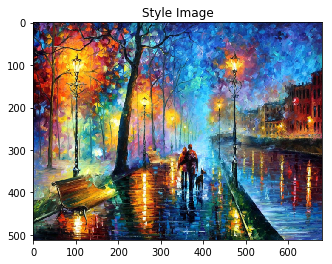

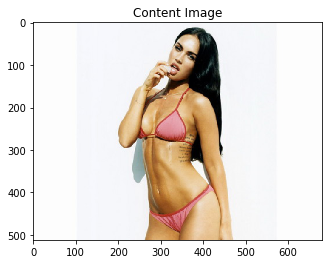

In [36]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [48]:
class ContentLoss(nn.Module):
    
    def __init__(self, target,):
        super(ContetLoss, self).__init__()
        
        # `detach`ing the target content from the tree
        # to dynamically computer the gradient
        # this is a stated value, not a variable.
        
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [49]:
def gram_matrix(input):
    # a -> batch size(=1)
    # b -> no of feature maps
    # (c,d) -> dimensions of f. map (N=c*d)
    a,b,c,d = input.size()
    
    # features
    features = input.view(a*b, c*d) # resizing Feature maps
    
    # Gram product
    G = torch.mm(features, features.t()) 
    
    # normalize the gram matrix and return
    return G.div(a*b*c*d)

In [50]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(input, self.target)
        return input

In [51]:
# VGG19 for feature extraction
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [52]:
cnn_norm_mean=torch.tensor([0.485,0.456,0.406]).to(device)
cnn_norm_std=torch.tensor([0.229,0.224,0.225]).to(device)

In [53]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
    
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [54]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3',
                        'conv_4','conv_5',]

In [56]:
def get_style_model_and_losses(cnn, norm_mean, norm_std,
                              style_img, content_img,
                content_layers=content_layers_default,
                style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)
    
    # norm module
    normalization = Normalization(normalization_mean,
                                 normalization_std).to(device)
    
    # list of content & style losses
    content_losses = []
    style_losses = []
    
    # appending new nn.Sequential modules to
    # put into cnn's nn.Sequential
    model = nn.Sequential(normalization)
    
    i = 0 # increment for every `conv` layer
    for layer in cnn.children(): # iterating over all layers
        # conditions to check layer:
        
        # conv2d
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        
        # relu
        elif isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)
            name = 'relu_{}'.format(i)
        
        # maxpool2d
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}',format(i)
        
        # batchnorm2d
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'pool_{}',format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.\
                              format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content losss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i),
                                content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module('style_loss_{}'.format(i),
                                style_loss)
            style_losses.append(style_loss)
            
    # now we trim off the layers after the last content
    # and style losses
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss)\
        or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

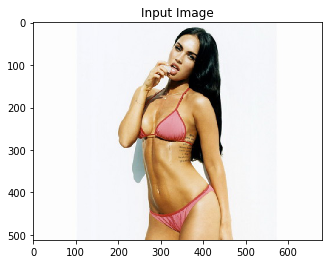

In [60]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [62]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn,normalization_mean,
                       normalization_std,
                      content_img, style_img, input_img.
                      num_steps=300, style_weight=100000,
                      content_weight=1):
    """
    Run the style transfer
    """
    print('Building the style transfer model...')
    